## 8.2. Line search

### №1

Показать, что условию Армихо $f(x_k - \alpha \nabla f (x_k)) \leq f(x_k) - c_1 \cdot \alpha\|\nabla f(x_k)\|_2^2$ удовлетворяют минмимумы квадратичных функций, убывающих в нуле для $c_1\in[0, 0.5]$.

**<u>Реш.</u>** Что будем делать? Напишем функцию поиска для параметра $\alpha$, выбрав начальное его значение достаточно большим и заведомо не удовлетворяющим условию Армихо. Далее будем уменьшать этот большой $\alpha$ до тех пор, пока условие не будет выполнено.

In [34]:
import numpy as np

def armijo_alpha_finder(f, grad_f, x_k, c1=0.25, alpha0=100.0, r=0.95):
    """процедура поиска шага градиентного спуска"""
    alpha = alpha0
    # до тех пор, пока не выполняется Армихо, уменьшаем альфа
    while f(x_k - alpha * grad_f(x_k)) > f(x_k) - c1 * alpha * np.linalg.norm(grad_f(x_k))**2:
        alpha *= r
    return alpha


def f1(x):
    """берём рандомную квадратичную функцию, которая убывает в нуле"""
    return (x - 3)**2 + 6

def grad_f1(x):
    """градиент первой функции"""
    return 2 * (x - 3)

def f2(x):
    """берём ещё одну рандомную квадратичную функцию, которая убывает в нуле"""
    return (2*x - 5)**2 - 1

def grad_f2(x):
    """градиент второй функции"""
    return 2 * (2*x - 5) * 2


x0 = 0.0
alpha1 = armijo_alpha_finder(f1, grad_f1, x0)
alpha2 = armijo_alpha_finder(f2, grad_f2, x0)
print(f'alpha1 = {alpha1}')
print(f'alpha2 = {alpha2}')

alpha1 = 0.7268856709612723
alpha2 = 0.18197153164363342


Видим, что для двух рассмотренных функций, которые удовлетворяют условию задачи, выполнено условие Армихо.

Теперь покажем аналитически выполнение данного условия, взяв общий вид квадратичной функции, убывающей в нуле.



**<u>Ответ:</u>** для обоих предложенных ф-ий найдены шаги градиентного спуска из условия Армихо, доказано аналитически.

### №2

Код, предоставленный в задании:

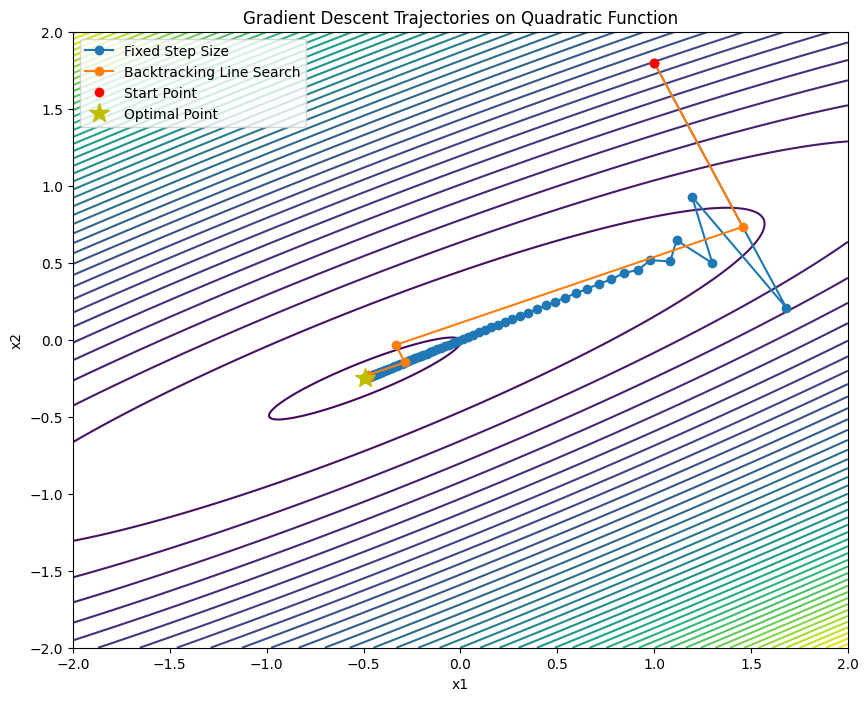

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
np.random.seed(214)

# Define the quadratic function and its gradient
def quadratic_function(x, A, b):
    return 0.5 * np.dot(x.T, np.dot(A, x)) - np.dot(b.T, x)

def grad_quadratic(x, A, b):
    return np.dot(A, x) - b

# Generate a 2D quadratic problem with a specified condition number
def generate_quadratic_problem(cond_number):
    # Random symmetric matrix
    M = np.random.randn(2, 2)
    M = np.dot(M, M.T)

    # Ensure the matrix has the desired condition number
    U, s, V = np.linalg.svd(M)
    s = np.linspace(cond_number, 1, len(s))  # Spread the singular values
    A = np.dot(U, np.dot(np.diag(s), V))

    # Random b
    b = np.random.randn(2)

    return A, b

# Gradient descent function
def gradient_descent(start_point, A, b, stepsize_func, max_iter=100):
    x = start_point.copy()
    trajectory = [x.copy()]

    for i in range(max_iter):
        grad = grad_quadratic(x, A, b)
        step_size = stepsize_func(x, grad)
        x -= step_size * grad
        trajectory.append(x.copy())

    return np.array(trajectory)

# Backtracking line search strategy using scipy
def backtracking_line_search(x, grad, A, b, alpha=0.3, beta=0.8):
    def objective(t):
        return quadratic_function(x - t * grad, A, b)
    res = minimize_scalar(objective, method='golden')
    return res.x

# Generate ill-posed problem
cond_number = 30
A, b = generate_quadratic_problem(cond_number)

# Starting point
start_point = np.array([1.0, 1.8])

# Perform gradient descent with both strategies
trajectory_fixed = gradient_descent(start_point, A, b, lambda x, g: 5e-2)
trajectory_backtracking = gradient_descent(start_point, A, b, lambda x, g: backtracking_line_search(x, g, A, b))

# Plot the trajectories on a contour plot
x1, x2 = np.meshgrid(np.linspace(-2, 2, 400), np.linspace(-2, 2, 400))
Z = np.array([quadratic_function(np.array([x, y]), A, b) for x, y in zip(x1.flatten(), x2.flatten())]).reshape(x1.shape)

plt.figure(figsize=(10, 8))
plt.contour(x1, x2, Z, levels=50, cmap='viridis')
plt.plot(trajectory_fixed[:, 0], trajectory_fixed[:, 1], 'o-', label='Fixed Step Size')
plt.plot(trajectory_backtracking[:, 0], trajectory_backtracking[:, 1], 'o-', label='Backtracking Line Search')

# Add markers for start and optimal points
plt.plot(start_point[0], start_point[1], 'ro', label='Start Point')
optimal_point = np.linalg.solve(A, b)
plt.plot(optimal_point[0], optimal_point[1], 'y*', markersize=15, label='Optimal Point')

plt.legend()
plt.title('Gradient Descent Trajectories on Quadratic Function')
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig("linesearch.svg")
plt.show()

1. Нам нужно написать ещё 5 stepsize_func, которые будут по разному подбирать размер шага. При этом надо будет сравнить траектории с теми, что уже были даны. Начнём с по порядку с Sufficient Decrease Condition (как я понял, это условие Армихо).

In [36]:
def armijo_line_search(x, g, A, b, alpha0=1.0, beta=0.9, c1=1e-4, max_iter=50):
    num_iter = 0
    alpha = alpha0
    while quadratic_function(x - alpha * g, A, b) > quadratic_function(x, A, b) - c1 * alpha * np.linalg.norm(g)**2:
        alpha *= beta
        num_iter += 1
        if alpha < 1e-10 or num_iter > max_iter:  # завершаем при достаточно малом шаге во избежание бесконечного цикла
            break
    return alpha

Теперь Goldstein Conditions:

In [37]:
def goldstein_line_search(x, grad, A, b, alpha0=1.0, beta=0.9, gamma=0.95, c1=1e-4, max_iter=50):
    alpha = alpha0
    phi_0 = quadratic_function(x, A, b)  # функция в начальной точке
    phi_grad_0 = np.dot(grad, grad)  # градиент в начальной точке
    for _ in range(max_iter):
        new_x = x - alpha * grad
        phi_alpha = quadratic_function(new_x, A, b)
        
        # Проверка нижнего условия Гольдштейна
        if phi_alpha > phi_0 + c1 * alpha * phi_grad_0:
            alpha *= beta  
        # Проверка верхнего условия Гольдштейна
        elif phi_alpha < phi_0 + (1 - c1) * alpha * phi_grad_0:
            alpha /= gamma  # увеличиваем размер шага при не выполнении верхнего условия
        else:
            break  # если оба условия Гольдштейна выполнены, то прерываем и берём текущее значение альфа
        
        # если альфа слишком большое или слишком маленькое, то прерываем цикл
        if alpha < 1e-10 or alpha > 1e10:
            break

    return alpha

Curvature condition:

In [69]:
def curvature_line_search(x, grad, A, b, alpha0=5e-2, beta=0.5, c2=0.9, max_iter=100):
    alpha = alpha0
    for _ in range(max_iter):
        if -np.dot(grad_quadratic(x - alpha * grad, A, b).T, grad) >= c2 * np.dot(grad.T, -grad):
            break  # условие кривизны выполнено - выходим из цикла
        alpha *= beta  # уменьшаем шаг в случае невыполненного условия кривизны
        if alpha < 1e-10:
            break  # прерываем при слишком малом шаге
    return alpha

Wolfe condition:

In [39]:
def wolfe_line_search(x, grad, A, b, beta=0.9, c1=1e-4, c2=0.9, max_iter=50):
    alpha = 1.0  # начальный размер шага
    d = -grad    # направление спуска

    for _ in range(max_iter):
        if ((quadratic_function(x + alpha * d, A, b) <= quadratic_function(x, A, b) + c1 * alpha * np.dot(grad.T, d)) and
            (np.dot(grad_quadratic(x + alpha * d, A, b).T, d) >= c2 * np.dot(grad.T, d))):
            # Оба условия Вульфа удовлетворены
            return alpha
        else:
            # Уменьшаем размер шага
            alpha *= beta

    # Если не найдено подходящее значение alpha, возвращаем последнее
    return alpha

Dichotomy:

In [40]:
def dichotomy_line_search(x, grad, A, b, a=0, u=1, tol=1e-5):
    while (u - a) / 2 > tol:
        c = (a + u) / 2
        left = c - tol / 2
        right = c + tol / 2
        
        if quadratic_function(x - left * grad, A, b) < quadratic_function(x - right * grad, A, b):
            u = c
        else:
            a = c
    
    return (a + u) / 2

Теперь строим траектории для каждого случая. Начинаем теперь с точки $x_0=(-1, 2)^T$.

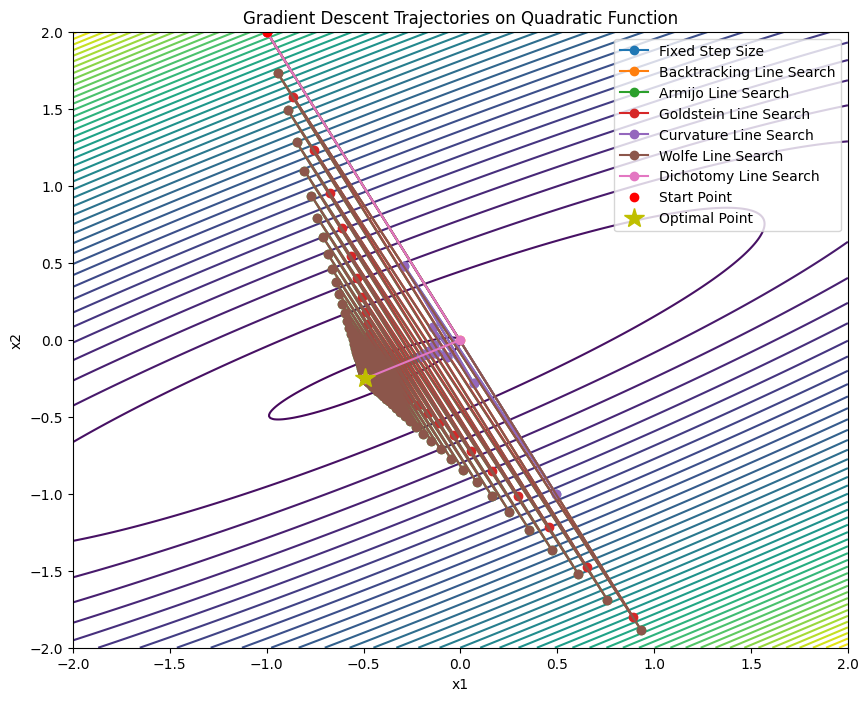

In [82]:
# Starting point
start_point = np.array([-1., 2.])

# Perform gradient descent with all strategies
trajectory_fixed = gradient_descent(start_point, A, b, lambda x, g: 5e-2)
trajectory_backtracking = gradient_descent(start_point, A, b, lambda x, g: backtracking_line_search(x, g, A, b))
trajectory_armijo = gradient_descent(start_point, A, b, lambda x, g: armijo_line_search(x, g, A, b))
trajectory_goldstein = gradient_descent(start_point, A, b, lambda x, g: goldstein_line_search(x, g, A, b))
trajectory_curvature = gradient_descent(start_point, A, b, lambda x, g: curvature_line_search(x, g, A, b))
trajectory_wolfe = gradient_descent(start_point, A, b, lambda x, g: wolfe_line_search(x, g, A, b))
trajectory_dichotomy = gradient_descent(start_point, A, b, lambda x, g: dichotomy_line_search(x, g, A, b))

# Plot the trajectories on a contour plot
x1, x2 = np.meshgrid(np.linspace(-2, 2, 400), np.linspace(-2, 2, 400))
Z = np.array([quadratic_function(np.array([x, y]), A, b) for x, y in zip(x1.flatten(), x2.flatten())]).reshape(x1.shape)

plt.figure(figsize=(10, 8))
plt.contour(x1, x2, Z, levels=50, cmap='viridis')
plt.plot(trajectory_fixed[:, 0], trajectory_fixed[:, 1], 'o-', label='Fixed Step Size')
plt.plot(trajectory_backtracking[:, 0], trajectory_backtracking[:, 1], 'o-', label='Backtracking Line Search')
plt.plot(trajectory_armijo[:, 0], trajectory_armijo[:, 1], 'o-', label='Armijo Line Search')
plt.plot(trajectory_goldstein[:, 0], trajectory_goldstein[:, 1], 'o-', label='Goldstein Line Search')
plt.plot(trajectory_curvature[:, 0], trajectory_curvature[:, 1], 'o-', label='Curvature Line Search')
plt.plot(trajectory_wolfe[:, 0], trajectory_wolfe[:, 1], 'o-', label='Wolfe Line Search')
plt.plot(trajectory_dichotomy[:, 0], trajectory_dichotomy[:, 1], 'o-', label='Dichotomy Line Search')

# Add markers for start and optimal points
plt.plot(start_point[0], start_point[1], 'ro', label='Start Point')
optimal_point = np.linalg.solve(A, b)
plt.plot(optimal_point[0], optimal_point[1], 'y*', markersize=15, label='Optimal Point')

plt.legend()
plt.title('Gradient Descent Trajectories on Quadratic Function')
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig("linesearch.svg")
plt.show()

Вот таким образом мы построили line search разными методами. Почти все методы для данной функции сходятся. Если честно, то возникли проблемы с Curvature condition. Я точно не могу сказать, почему это происходит. Очень долго пытался подобрать разные гиперпараметры. В случае с Goldstein это помогло (с ним тоже сначала были проблемы), но Curvature не сходится в любом случае. При дебаге выяснилось, что просто if, стоящий внутри линейного поиска этим методом никогда не срабатывает. Для того, чтобы получить картину выше пришлось ставить alpha0=5e-2, как у постоянного шага. Я полагаю, что Curvature не даёт сходимость тут из-за вида данной в 1-м пункте функции. Во 2 пункте из-за этого, количество обращений к Curvature мы вычислять не будем.

2. Теперь построим график зависимости значений функции для каждого метода от количества итераций на одном графике.

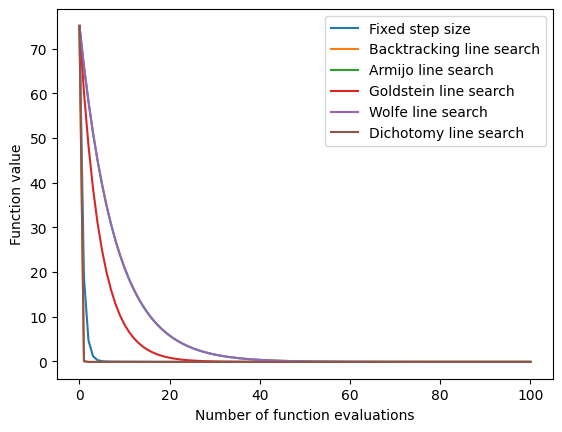

In [73]:
# Вычисляем  значения функций на каждой итерации градиентного спуска
func_values_fixed = [quadratic_function(x, A, b) for x in trajectory_fixed]
func_values_backtracking = [quadratic_function(x, A, b) for x in trajectory_backtracking]
func_values_armijo = [quadratic_function(x, A, b) for x in trajectory_armijo]
func_values_goldstein = [quadratic_function(x, A, b) for x in trajectory_goldstein]
func_values_wolfe = [quadratic_function(x, A, b) for x in trajectory_wolfe]
func_values_dichotomy = [quadratic_function(x, A, b) for x in trajectory_dichotomy]

# Создаём 
fig, ax = plt.subplots()

# Number of function evaluations
x = range(len(func_values_fixed))

# Plot function values for each method
ax.plot(x, func_values_fixed, label='Fixed step size')
ax.plot(x, func_values_backtracking, label='Backtracking line search')
ax.plot(x, func_values_armijo, label='Armijo line search')
ax.plot(x, func_values_goldstein, label='Goldstein line search')
ax.plot(x, func_values_wolfe, label='Wolfe line search')
ax.plot(x, func_values_dichotomy, label='Dichotomy line search')


ax.legend()
ax.set_xlabel('Number of function evaluations')
ax.set_ylabel('Function value')

plt.savefig("funevaluations.png")
plt.show()

Видим, что большего количества обращений к функции требует Wolfe. Дихотомия и Бэктрекинг выигрвыают по этому показателю, для достижения решения им требуется меньшее число вызва функции.

3. Теперь рассмотрим функцию $f(x_1, x_2) =  10(x_2 − x_1^2)^2 + (x_1 − 1)^2$. И проведём всё тоже самое для неё.
   

In [81]:
def another_quadratic_function(x: np.ndarray):
    return 10 * (x[1]-x[0]**2)**2 + (x[0]-1)**2

def another_grad_quadratic(x: np.ndarray):
    return np.array([40*(x[0]**3-x[0]*x[1])+2*(x[0]-1), 20*(x[1]-x[0]**2)])



# Gradient descent function
def gradient_descent(start_point, stepsize_func, max_iter=100):
    x = start_point.copy()
    trajectory = [x.copy()]

    for i in range(max_iter):
        grad = another_grad_quadratic(x, A, b)
        step_size = stepsize_func(x, grad)
        x -= step_size * grad
        trajectory.append(x.copy())

    return np.array(trajectory)

# Backtracking line search strategy using scipy
def backtracking_line_search(x, grad, alpha=0.3, beta=0.8):
    def objective(t):
        return quadratic_function(x - t * grad, A, b)
    res = minimize_scalar(objective, method='golden')
    return res.x

# Starting point
start_point = np.array([1.0, 1.8])

# Perform gradient descent with both strategies
trajectory_fixed = gradient_descent(start_point, A, b, lambda x, g: 5e-2)
trajectory_backtracking = gradient_descent(start_point, A, b, lambda x, g: backtracking_line_search(x, g, A, b))

# Plot the trajectories on a contour plot
x1, x2 = np.meshgrid(np.linspace(-2, 2, 400), np.linspace(-2, 2, 400))
Z = np.array([quadratic_function(np.array([x, y]), A, b) for x, y in zip(x1.flatten(), x2.flatten())]).reshape(x1.shape)

plt.figure(figsize=(10, 8))
plt.contour(x1, x2, Z, levels=50, cmap='viridis')
plt.plot(trajectory_fixed[:, 0], trajectory_fixed[:, 1], 'o-', label='Fixed Step Size')
plt.plot(trajectory_backtracking[:, 0], trajectory_backtracking[:, 1], 'o-', label='Backtracking Line Search')

# Add markers for start and optimal points
plt.plot(start_point[0], start_point[1], 'ro', label='Start Point')
optimal_point = np.linalg.solve(A, b)
plt.plot(optimal_point[0], optimal_point[1], 'y*', markersize=15, label='Optimal Point')

plt.legend()
plt.title('Gradient Descent Trajectories on Quadratic Function')
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig("linesearch.svg")
plt.show()

14.0
[36. 20.]
